# CASSANDRA

##### Crear la BBDD

CREATE KEYSPACE incidents
 WITH replication = {
'class':'SimpleStrategy',
 'replication_factor':1
}

##### Consultas

Hemos optado por hacer una tabla principal con todos los datos, junto a otras tablas más pequeñas para consultas específicas como por ejemplo incidentes por distritos, días de la semana, categorías, descripciones, etc.
 
Es decir, consultas para agilizar el proceso y tener acceso a la información de manera mucho más inmediata que realizando búsquedas sobre la primera tabla original.

Para obtener estas tablas hemos seguido el siguiente proceso:
    - Hacer las consultas sobre la tabla original del csv con todos los datos
    - Exportar el resultado (por ejemplo, incidencias por categoria) a csv
    - Utilizar el nuevo csv para crear una consulta/tabla nueva en Cassandra
    - Refactorizar el codigo en Python para usar ahora la llamada no a la consulta original sino a esta segunda version mucho más simple y eficiente

Junto a ello, también incluimos gráficos para ver de manera mucho mas simplificada y directa la información contenida en las tablas y dataframes.

##### Tablas
CREATE TABLE incidents.datosbasicos(
	incidentNumber text,
	category text,
	descript text,
	dayofweek text,
	date date,
	time time,
	pddistrict text,
	resolution text,
	address text,
	x text,
	y text,
	location text,
	pdid text,
	PRIMARY KEY(incidentNumber, category,dayofweek, date, time, pddistrict, resolution, address, x, y, location, pdid)
);

CREATE TABLE incidents.categoriasmasfrecuentes(
    category text,
    total text,
    PRIMARY KEY(category)
);

CREATE TABLE incidents.descripciones( row text, description text, PRIMARY KEY((description,row)) );



CREATE TABLE incidents.diassemanamasfrecuentes(
    dia text,
    total text,
    PRIMARY KEY(dia)
);

CREATE TABLE incidents.distritosmasfrecuentes(
    distrito text,
    total text,
    PRIMARY KEY(distrito)
);
    
##### Inserción de datos
Tras la creación, el siguiente paso es introducir los datos de que disponemos a través del CSV en esta primera consulta.

COPY incidents.datosbasicos (incidentNumber, category, descript, dayofweek, date, time, pddistrict, resolution, address, x, y, location, pdid) FROM 'C:\...\CSV.csv' WITH HEADER=TRUE and CHUNKSIZE=500 and INGESTRATE=2000;

##### Exportación de datos
Si por algún motivo queremos exportar alguna consulta a un CSV el proceso es el siguiente:

COPY incidents.datosbasicos (incidentNumber, category, descript, dayofweek, date, time, pddistrict, resolution, address, x, y, location, pdid) TO 'C:\...\temp.csv';

##### Borrar consulta
Por último, si queremos borrar una consulta no tenemos más que escribir:
DROP TABLE keyspace.table;

### Consultas realizadas
Hemos desarrollado las siguientes consultas en nuestro prototipo de Python con Cassandra:
    - Listar todos los datos disponibles en el CSV
    - Ver las cinco categorías con más incidentes
    - Ver el número de incidencias por día de la semana
    - Ver los cinco distritos con mayor número de incidencias
    - Buscar el número de incidentes aquellos que contengan cierta palabra en la descripción ('DOG' en nuestro ejemplo)
    - Ver el número de incidencias por bloques de días, esto es, del día 1 al 10, del 11 al 20, y del 21 hasta el resto.

In [1]:
from cassandra.cluster import Cluster
from cassandra.query import dict_factory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

cluster = Cluster()
session = cluster.connect('incidents')
session.row_factory = dict_factory

### DataFrame original

In [2]:
queryDatosBasicos = "SELECT * FROM datosbasicos"
dfDatosBasicos = pd.DataFrame(list(session.execute(queryDatosBasicos)))
dfDatosBasicos

,address,category,date,dayofweek,descript,incidentnumber,location,pddistrict,pdid,resolution,time,x,y
0,100 Block of 3RD ST,PROSTITUTION,2016-01-29,Friday,SOLICITS FOR ACT OF PROSTITUTION,160084328,"(37.78545749029967, -122.40091602902488)",SOUTHERN,16008432813060,"ARREST, BOOKED",14:00:00.000000000,-122.40091602902487,37.78545749029967
1,100 Block of 3RD ST,PROSTITUTION,2016-01-29,Friday,LOITERING FOR PURPOSE OF PROSTITUTION,160084328,"(37.78545749029967, -122.40091602902488)",SOUTHERN,16008432813075,"ARREST, BOOKED",14:00:00.000000000,-122.40091602902487,37.78545749029967
2,PINE ST / STOCKTON ST,LARCENY/THEFT,2006-06-03,Saturday,GRAND THEFT FROM LOCKED AUTO,60589373,"(37.7912964515689, -122.40734222874)",CENTRAL,6058937306244,NONE,18:00:00.000000000,-122.40734222873999,37.7912964515689
3,0 Block of TUCKER AV,VANDALISM,2008-11-30,Sunday,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",81280257,"(37.7155319865115, -122.404500268176)",INGLESIDE,8128025728160,NONE,01:00:00.000000000,-122.40450026817601,37.7155319865115
4,TURK ST / TAYLOR ST,DRUG/NARCOTIC,2008-07-30,Wednesday,POSSESSION OF BASE/ROCK COCAINE FOR SALE,80799853,"(37.7832145190013, -122.410768766343)",TENDERLOIN,8079985316623,"ARREST, BOOKED",06:42:00.000000000,-122.410768766343,37.7832145190013
5,1100 Block of SCOTT ST,VANDALISM,2005-11-10,Thursday,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",51269758,"(37.7803348745141, -122.437236101904)",PARK,5126975828160,NONE,01:20:00.000000000,-122.43723610190399,37.780334874514104
6,0 Block of DANIELBURNHAM CT,LARCENY/THEFT,2007-02-01,Thursday,PETTY THEFT FROM LOCKED AUTO,70114794,"(37.7870192301761, -122.42254731779)",NORTHERN,7011479406242,NONE,08:20:00.000000000,-122.42254731778999,37.7870192301761
7,0 Block of TINGLEY ST,NON-CRIMINAL,2008-01-19,Saturday,LOST PROPERTY,86006127,"(37.7287340517921, -122.432948738078)",INGLESIDE,8600612771000,NONE,10:00:00.000000000,-122.432948738078,37.7287340517921
8,1300 Block of FELL ST,BURGLARY,2005-02-06,Sunday,"BURGLARY OF APARTMENT HOUSE, UNLAWFUL ENTRY",50147088,"(37.7737933965852, -122.440126155736)",PARK,5014708805013,NONE,16:00:00.000000000,-122.44012615573601,37.773793396585205
9,400 Block of BROADWAY ST,ASSAULT,2013-01-29,Tuesday,THREATS AGAINST LIFE,130082073,"(37.7982249345487, -122.404282497745)",CENTRAL,13008207319057,NONE,13:00:00.000000000,-122.404282497745,37.7982249345487


### Incidentes por categoría

In [3]:
queryCategorias = "SELECT * FROM categoriasmasfrecuentes"
categoriasMasFrecuentes = pd.DataFrame(list(session.execute(queryCategorias)))
categoriasMasFrecuentes['total'] = categoriasMasFrecuentes['total'].astype('int')
categoriasOrdenadas = categoriasMasFrecuentes.sort_values('total', ascending=False).head(5)

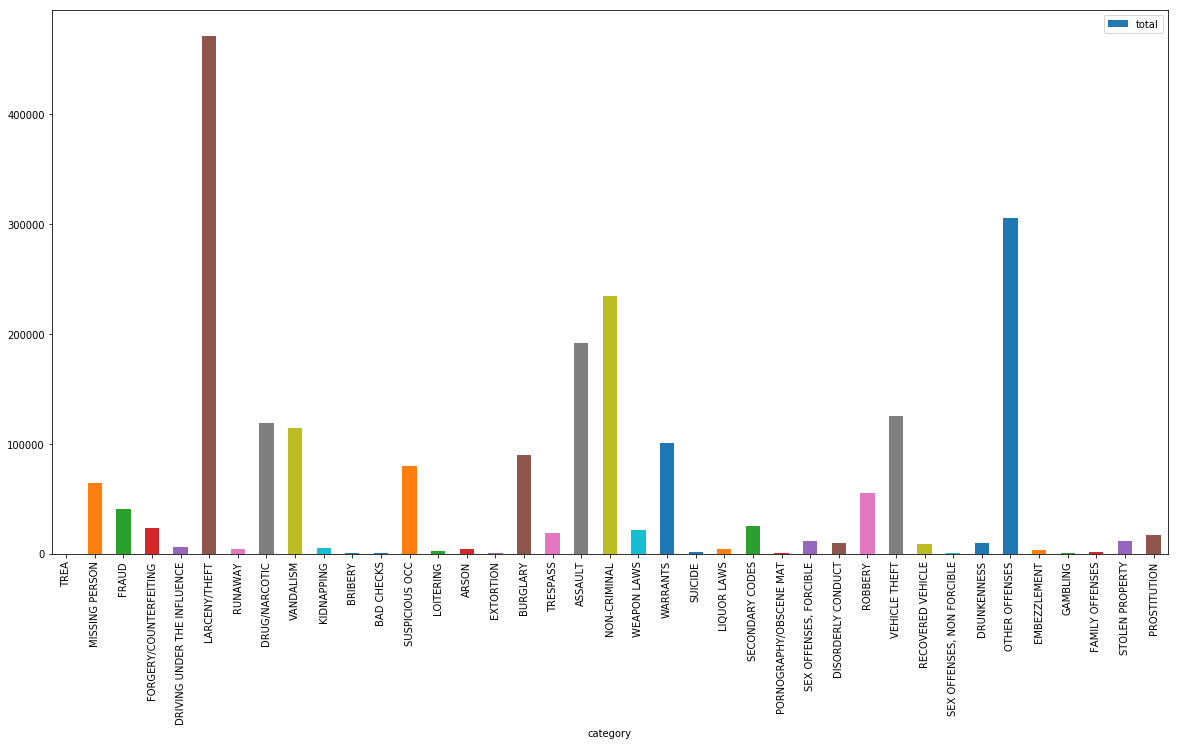

In [4]:
categoriasMasFrecuentes.plot("category", "total", kind = "bar", figsize = (20, 10))

### Las cinco categorías más frecuentes

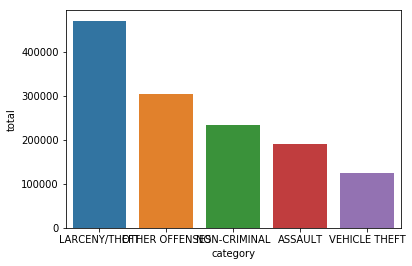

In [5]:
sns.barplot(x='category',y='total',data=categoriasOrdenadas)

### Incidentes por día de la semana

In [6]:
queryDiasSemana = "SELECT * FROM diassemanamasfrecuentes"
diasSemanaMasFrecuentes = pd.DataFrame(list(session.execute(queryDiasSemana)))
diasSemanaMasFrecuentes['total'] = diasSemanaMasFrecuentes['total'].astype('int')
diasSemanaMasFrecuentes

,dia,total
0,Thursday,311705
1,Saturday,316019
2,Friday,333109
3,Wednesday,319498
4,Sunday,290528
5,Monday,302397
6,Tuesday,310977


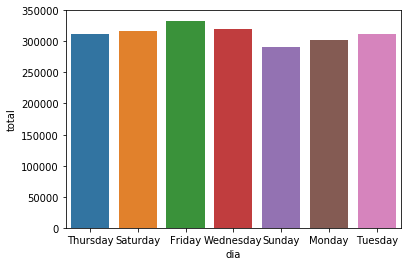

In [7]:
sns.barplot(x='dia',y='total',data=diasSemanaMasFrecuentes)

### Incidentes por distritos

In [8]:
queryDistritosFrecuentes = "SELECT * FROM distritosmasfrecuentes"
distritosMasFrecuentes = pd.DataFrame(list(session.execute(queryDistritosFrecuentes)))
distritosMasFrecuentes['total'] = distritosMasFrecuentes['total'].astype('int')
distritosOrdenados = distritosMasFrecuentes.head(5)

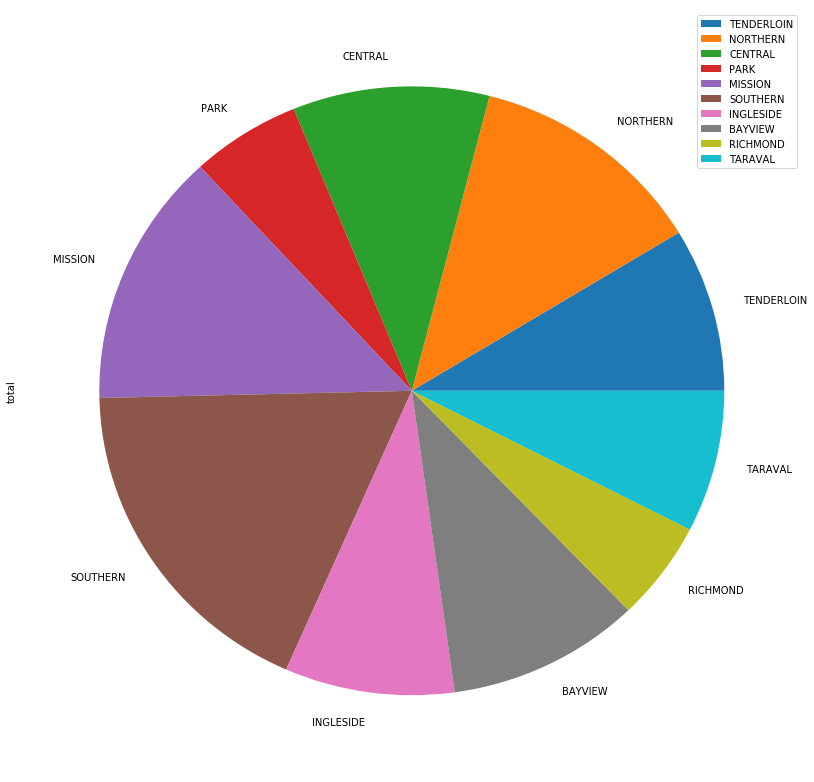

In [9]:
distritosMasFrecuentes.plot("distrito", "total", kind = "pie",
               labels = distritosMasFrecuentes["distrito"], figsize = (14, 14))

### Los cinco distritos más frecuentes

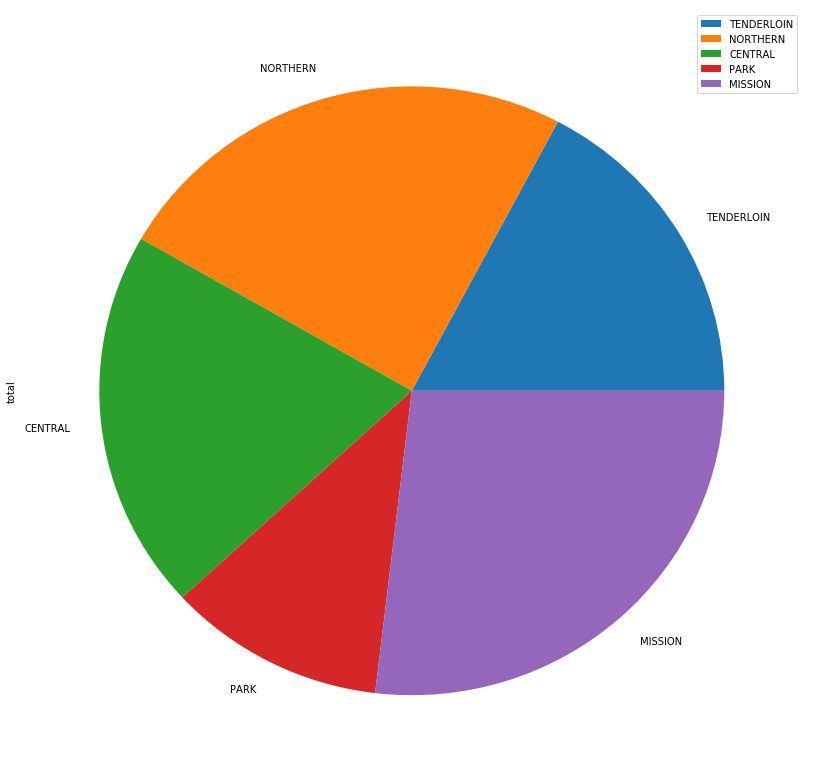

In [10]:
distritosOrdenados.plot("distrito", "total", kind = "pie",
               labels = distritosOrdenados["distrito"], figsize = (14, 14))

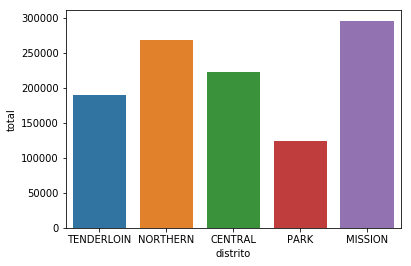

In [11]:
sns.barplot(x='distrito',y='total',data=distritosOrdenados)

### Descripciones

In [12]:
queryDescripciones = "SELECT * FROM descripciones"
descripciones = pd.DataFrame(list(session.execute(queryDescripciones)))
descripciones

,description,row
0,"BURGLARY OF RESIDENCE, UNLAWFUL ENTRY",396875
1,GRAND THEFT FROM LOCKED AUTO,489240
2,"FORGERY, DRIVERS LICENSE OR ID-CARD",844879
3,"AIDED CASE, MENTAL DISTURBED",44402
4,"CIVIL SIDEWALKS, WARNING",1371418
5,STOLEN TRUCK,1823570
6,BATTERY,1537787
7,GRAND THEFT FROM LOCKED AUTO,854935
8,PETTY THEFT FROM A BUILDING,422910
9,"DRIVERS LICENSE, SUSPENDED OR REVOKED",145643


### Ocurrencias de la palabra 'DOG'

In [13]:
ocurrenciasDOG = pd.DataFrame()
ocurrenciasDOG = descripciones['description'][descripciones['description'].str.contains('DOG')]
ocurrenciasDOG.count()

3677

### Incidencias por intervalos de días
#### (Día 1 a 10, 11 a 20 y 21 en adelante)

In [14]:
diasPrimerTercio = pd.Series()
diasSegundoTercio = pd.Series()
diasTercerTercio = pd.Series()
diasFuenteOriginal = pd.DataFrame()

def sacarNumDia(date):
    date_aux = str(date)
    return str(date_aux[8:10])

In [15]:
diasFuenteOriginal = dfDatosBasicos['date'].apply(sacarNumDia)
dataAux1 = []
dataAux2 = []
dataAux3 = []

for day in diasFuenteOriginal:
    aux = int(day)
    if(aux<=10):
        dataAux1.append(day)
    elif(aux>10 and aux<=20):
        dataAux2.append(day)
    else:
        dataAux3.append(day)

In [16]:
diasPrimerTercio = pd.DataFrame(dataAux1)
diasPrimerTercio.count()

0    724005
dtype: int64

In [17]:
diasSegundoTercio = pd.DataFrame(dataAux2)
diasSegundoTercio.count()

0    718393
dtype: int64

In [18]:
diasTercerTercio = pd.DataFrame(dataAux3)
diasTercerTercio.count()

0    741835
dtype: int64

In [19]:
diasPorTercios = pd.DataFrame()
diasPorTercios['indices'] = [1,2,3]
diasPorTercios['dias'] = [724005,718393,741835]
diasPorTercios

,indices,dias
0,1,724005
1,2,718393
2,3,741835


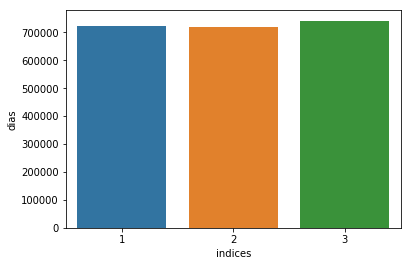

In [20]:
sns.barplot(x='indices',y='dias',data=diasPorTercios)